# Análise de solicitação de crédito

**Objetivo desta análise**: determinar para cada solicitação de crédito o valor de **Risk** baseado nos outros atributos (por exemplo, Age, Sex, Job, Housing, ...).

Este dataset e a descrição do problema estão disponíveis em https://www.kaggle.com/uciml/german-credit

$Risk \leftarrow Age + Sex + Job + \cdots + Purpose$

Este dataset é um dataset desbalanceado. Na V1 deste script a medida utilizada para avaliar o modelo foi a acurácia. No entanto, acurácia não é a melhor medida para avaliar o desempenho de problemas cujo a variável de interesse é desbalanceada.

## Aquisição dos dados e pré-processamento

In [512]:
import pandas as pd
#df = pd.read_csv("https://raw.githubusercontent.com/fbarth/ml-espm/master/dataset/german_credit_data.csv")
df = pd.read_csv("../../dataset/german_credit_data.csv")

In [513]:
type(df)

pandas.core.frame.DataFrame

In [514]:
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [515]:
df.shape

(1000, 11)

In [516]:
df = df.drop(columns=['Unnamed: 0'])

## Análise descritiva

In [517]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [518]:
df = df.rename(columns={
    "Age": "age", 
    "Sex": "sex", 
    "Job": "job", 
    "Housing": "housing", 
    "Saving accounts": "savingAccount",
    "Checking account": "checkingAccount",
    "Credit amount": "creditAmount",
    "Duration": "duration",
    "Purpose": "purpose",
    "Risk": "risk"
})

In [519]:
df.head()

,age,sex,job,housing,savingAccount,checkingAccount,creditAmount,duration,purpose,risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [520]:
df['risk'].value_counts()

good    700
bad     300
Name: risk, dtype: int64

Visto que a variável Risk é categórica então podemos dizer que este é um problema de **classificação**.

Isto é importante para: 
* Definir as métricas de como o modelo será avaliado, e;
* Escolher o melhor algoritmo para criar o modelo.

Descrição dos atributos: 

* Age (numeric)
* Sex (text: male, female)
* Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
* Housing (text: own, rent, or free)
* Saving accounts (text - little, moderate, quite rich, rich)
* Checking account (numeric, in DM - Deutsch Mark)
* Credit amount (numeric, in DM)
* Duration (numeric, in month)
* Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)

*Dúvida*: deixamos o atributo Job como número ou transformamos para categórico? 

In [521]:
cleanup_nums = {"savingAccount": 
                {"little": 1, "moderate": 2, "quite rich": 3, "rich": 4}
               }
df.replace(cleanup_nums, inplace=True)
df.head()

,age,sex,job,housing,savingAccount,checkingAccount,creditAmount,duration,purpose,risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,1.0,moderate,5951,48,radio/TV,bad
2,49,male,1,own,1.0,NaN,2096,12,education,good
3,45,male,2,free,1.0,little,7882,42,furniture/equipment,good
4,53,male,2,free,1.0,little,4870,24,car,bad


In [522]:
cleanup_nums = {"checkingAccount": 
                {"little": 1, "moderate": 2, "quite rich": 3, "rich": 4}
               }
df.replace(cleanup_nums, inplace=True)
df.head()

,age,sex,job,housing,savingAccount,checkingAccount,creditAmount,duration,purpose,risk
0,67,male,2,own,NaN,1.0,1169,6,radio/TV,good
1,22,female,2,own,1.0,2.0,5951,48,radio/TV,bad
2,49,male,1,own,1.0,NaN,2096,12,education,good
3,45,male,2,free,1.0,1.0,7882,42,furniture/equipment,good
4,53,male,2,free,1.0,1.0,4870,24,car,bad


<AxesSubplot:ylabel='Frequency'>

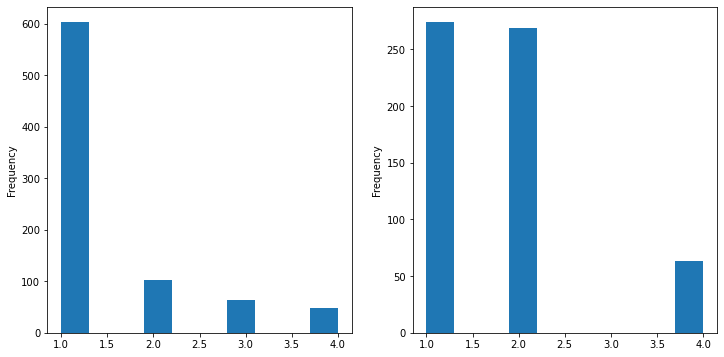

In [523]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6)) 
df['savingAccount'].plot(kind='hist', ax=axes[0])
df['checkingAccount'].plot(kind='hist', ax=axes[1])

<AxesSubplot:>

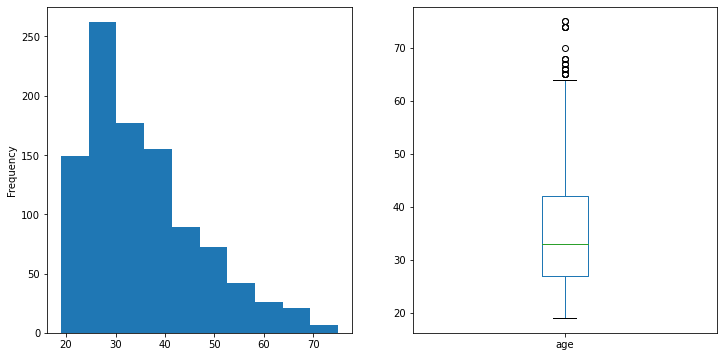

In [524]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6)) 
df['age'].plot(kind='hist', ax=axes[0])
df['age'].plot(kind='box', ax=axes[1])

In [525]:
df['age'].describe()

count    1000.000000
mean       35.546000
std        11.375469
min        19.000000
25%        27.000000
50%        33.000000
75%        42.000000
max        75.000000
Name: age, dtype: float64

<AxesSubplot:ylabel='Frequency'>

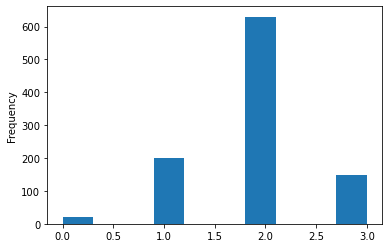

In [526]:
df['job'].plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

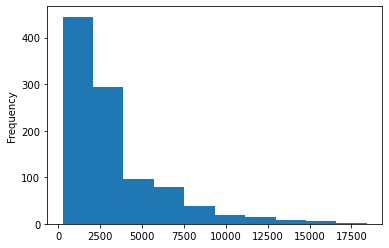

In [527]:
df['creditAmount'].plot(kind='hist')

In [528]:
df['creditAmount'].describe()

count     1000.000000
mean      3271.258000
std       2822.736876
min        250.000000
25%       1365.500000
50%       2319.500000
75%       3972.250000
max      18424.000000
Name: creditAmount, dtype: float64

<AxesSubplot:>

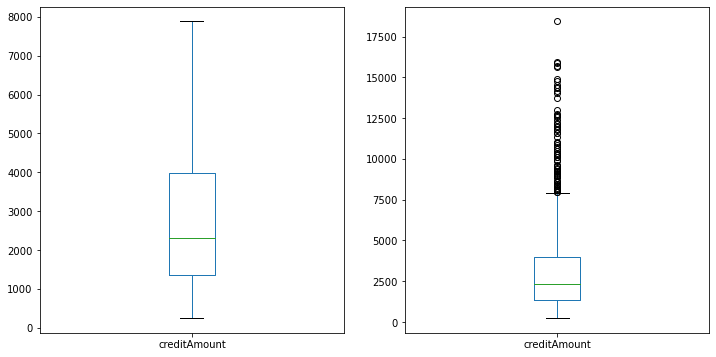

In [529]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6)) 
#figure(figsize=(7,5))
df['creditAmount'].plot(kind='box', showfliers=False, ax=axes[0])
df['creditAmount'].plot(kind='box', ax=axes[1])

In [530]:
df['sex'].value_counts()

male      690
female    310
Name: sex, dtype: int64

In [531]:
df['job'].value_counts()

2    630
1    200
3    148
0     22
Name: job, dtype: int64

In [532]:
df['housing'].value_counts()

own     713
rent    179
free    108
Name: housing, dtype: int64

In [533]:
df['savingAccount'].value_counts()

1.0    603
2.0    103
3.0     63
4.0     48
Name: savingAccount, dtype: int64

In [534]:
df['savingAccount'].isnull().sum() / df.shape[0]

0.183

In [535]:
df['checkingAccount'].value_counts()

1.0    274
2.0    269
4.0     63
Name: checkingAccount, dtype: int64

In [536]:
df['checkingAccount'].isnull().sum() / df.shape[0]

0.394

In [537]:
df.head()

,age,sex,job,housing,savingAccount,checkingAccount,creditAmount,duration,purpose,risk
0,67,male,2,own,NaN,1.0,1169,6,radio/TV,good
1,22,female,2,own,1.0,2.0,5951,48,radio/TV,bad
2,49,male,1,own,1.0,NaN,2096,12,education,good
3,45,male,2,free,1.0,1.0,7882,42,furniture/equipment,good
4,53,male,2,free,1.0,1.0,4870,24,car,bad


<AxesSubplot:>

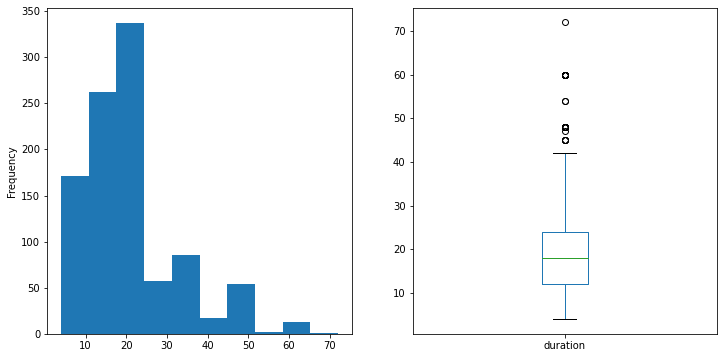

In [538]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6)) 
df['duration'].plot(kind='hist', ax=axes[0])
df['duration'].plot(kind='box', ax=axes[1])

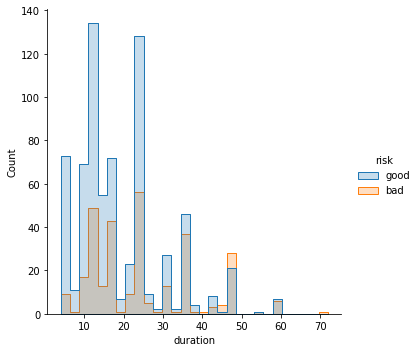

In [539]:
import seaborn as sns
sns.displot(df, x="duration", hue="risk", element="step")

In [540]:
df['purpose'].value_counts()

car                    337
radio/TV               280
furniture/equipment    181
business                97
education               59
repairs                 22
domestic appliances     12
vacation/others         12
Name: purpose, dtype: int64

In [541]:
df['purpose'].isnull().sum() / df.shape[0]

0.0

In [542]:
df['risk'].isnull().sum() / df.shape[0]

0.0

In [543]:
df.isnull().sum()

age                  0
sex                  0
job                  0
housing              0
savingAccount      183
checkingAccount    394
creditAmount         0
duration             0
purpose              0
risk                 0
dtype: int64

In [598]:
df['account'] = df['savingAccount'] + df['checkingAccount']

In [599]:
df.isnull().sum()

age                  0
sex                  0
job                  0
housing              0
savingAccount      183
checkingAccount    394
creditAmount         0
duration             0
purpose              0
risk                 0
account            478
dtype: int64

Text(0, 0.5, 'Duration')

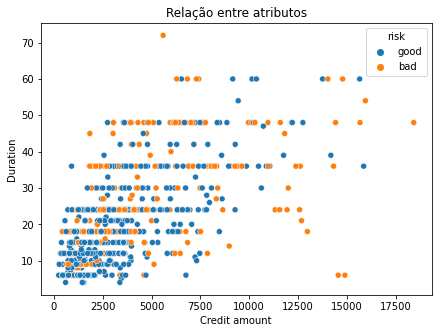

In [544]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 5))

import seaborn as sns
x = sns.scatterplot(x='creditAmount', y='duration', data=df, hue='risk')
x.set_title("Relação entre atributos")
x.set_xlabel("Credit amount")
x.set_ylabel("Duration")

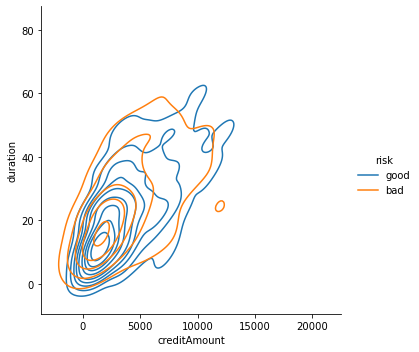

In [545]:
sns.displot(df, x="creditAmount", y="duration", hue='risk', kind="kde")

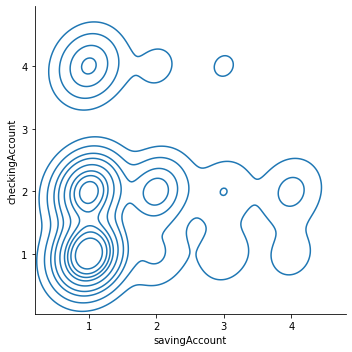

In [546]:
sns.displot(df, x="savingAccount", y="checkingAccount", kind="kde")

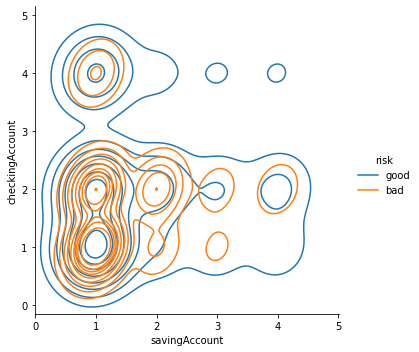

In [547]:
sns.displot(df, x="savingAccount", y="checkingAccount", hue='risk', kind="kde")

/Users/fabricio/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='creditAmount', ylabel='duration'>

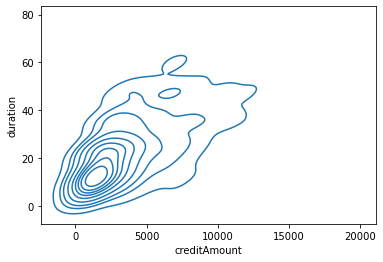

In [548]:
sns.kdeplot(df['creditAmount'], df['duration'])

/Users/fabricio/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/fabricio/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:1678: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0`, but please update your code.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='creditAmount', ylabel='duration'>

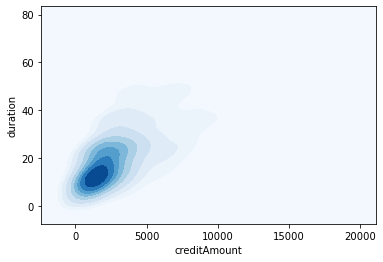

In [549]:
sns.kdeplot(df['creditAmount'], df['duration'], cmap="Blues", shade=True, shade_lowest=True)

Text(0.5, 0, 'Checking Account')

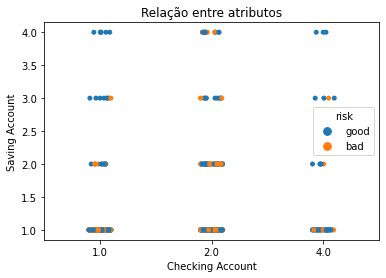

In [550]:
import seaborn as sns
x = sns.stripplot(x='checkingAccount', y='savingAccount', data=df, hue='risk', jitter=0.1)
x.set_title("Relação entre atributos")
x.set_ylabel("Saving Account")
x.set_xlabel("Checking Account")

bad          AxesSubplot(0.1,0.15;0.363636x0.75)
good    AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

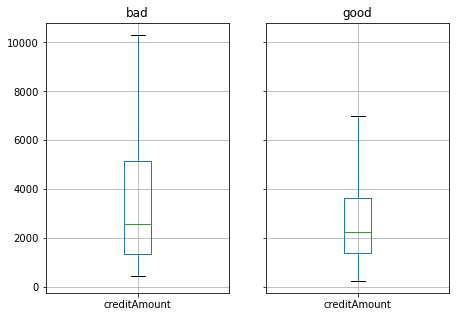

In [551]:
grouped = df[['creditAmount','risk']].groupby('risk')
grouped.boxplot(figsize=(7,5), showfliers=False)

In [552]:
df.shape

(1000, 10)

# Separando parte dos exemplos para validação final

In [553]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,0:9], df['risk'], test_size=0.1, random_state=4)

In [554]:
X_train.head()

,age,sex,job,housing,savingAccount,checkingAccount,creditAmount,duration,purpose
239,39,male,2,own,1.0,1.0,2522,30,radio/TV
304,44,male,2,free,3.0,NaN,10127,48,car
964,22,male,1,own,1.0,2.0,454,6,repairs
102,24,female,2,own,1.0,NaN,932,6,radio/TV
867,42,male,2,own,1.0,NaN,3331,12,furniture/equipment


In [555]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(900, 9)
(900,)
(100, 9)
(100,)


In [556]:
y_train.value_counts()

good    628
bad     272
Name: risk, dtype: int64

In [557]:
y_test.value_counts()

good    72
bad     28
Name: risk, dtype: int64

# Modelagem com algoritmos indutores de árvores de decisão

A atual implementação de árvore de decisão no sklearn (tree.DecisionTreeClassifier()) não consegue trabalhar com dados categóricos. Sendo assim, é necessário transformar os atributos categóricos em numéricos quando houver uma relação de grandeza entre os valores. Caso contrário, vamos simplesmente desconsiderar os atributos.

Por enquanto, não vamos considerar a abordagem de *one hot* ou *get_dummies* pois esta abordagem gera uma tabela com alta dimensionalidade - algo que algoritmos de árvore de decisão não conseguem lidar muito bem.

In [558]:
X_train.head()

,age,sex,job,housing,savingAccount,checkingAccount,creditAmount,duration,purpose
239,39,male,2,own,1.0,1.0,2522,30,radio/TV
304,44,male,2,free,3.0,NaN,10127,48,car
964,22,male,1,own,1.0,2.0,454,6,repairs
102,24,female,2,own,1.0,NaN,932,6,radio/TV
867,42,male,2,own,1.0,NaN,3331,12,furniture/equipment


In [559]:
#
# Removendo atributos categóricos e atributos numéricos com valores faltantes
# Obs.: O algoritmo DecisionTreeClassifier não consegue trabalhar com exemplos que tenham atributos
# faltantes.
#
X_train_ = X_train.drop(columns=['sex','housing','savingAccount','checkingAccount','purpose'])

In [560]:
X_train_

,age,job,creditAmount,duration
239,39,2,2522,30
304,44,2,10127,48
964,22,1,454,6
102,24,2,932,6
867,42,2,3331,12
...,...,...,...,...
897,35,2,1592,12
709,37,1,2118,9
439,26,0,609,12
174,26,2,3414,21


In [561]:
from sklearn import tree
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score, cross_val_predict
model = tree.DecisionTreeClassifier(max_depth=3)
model.fit(X_train_, y_train)
s = make_scorer(f1_score, pos_label='bad')
scores = cross_val_score(model, X_train_, y_train, cv=5, scoring=s)
y_pred = cross_val_predict(model, X_train_, y_train, cv=5)
print("f1-score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

f1-score: 0.21 (+/- 0.10)


In [562]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_train, y_pred))
from sklearn.metrics import classification_report, plot_confusion_matrix
print(classification_report(y_train, y_pred))

[[ 41 231]
 [ 52 576]]
              precision    recall  f1-score   support

         bad       0.44      0.15      0.22       272
        good       0.71      0.92      0.80       628

    accuracy                           0.69       900
   macro avg       0.58      0.53      0.51       900
weighted avg       0.63      0.69      0.63       900



[Text(153.45000000000002, 190.26, 'X[3] <= 29.0\ngini = 0.422\nsamples = 900\nvalue = [272, 628]'),
 Text(83.7, 135.9, 'X[2] <= 8630.5\ngini = 0.381\nsamples = 706\nvalue = [181, 525]'),
 Text(55.800000000000004, 81.53999999999999, 'X[3] <= 7.5\ngini = 0.374\nsamples = 699\nvalue = [174, 525]'),
 Text(27.900000000000002, 27.180000000000007, 'gini = 0.167\nsamples = 76\nvalue = [7, 69]'),
 Text(83.7, 27.180000000000007, 'gini = 0.392\nsamples = 623\nvalue = [167, 456]'),
 Text(111.60000000000001, 81.53999999999999, 'gini = 0.0\nsamples = 7\nvalue = [7, 0]'),
 Text(223.20000000000002, 135.9, 'X[0] <= 29.5\ngini = 0.498\nsamples = 194\nvalue = [91, 103]'),
 Text(167.4, 81.53999999999999, 'X[2] <= 4235.0\ngini = 0.465\nsamples = 68\nvalue = [43, 25]'),
 Text(139.5, 27.180000000000007, 'gini = 0.483\nsamples = 22\nvalue = [9, 13]'),
 Text(195.3, 27.180000000000007, 'gini = 0.386\nsamples = 46\nvalue = [34, 12]'),
 Text(279.0, 81.53999999999999, 'X[0] <= 41.5\ngini = 0.472\nsamples = 126\nva

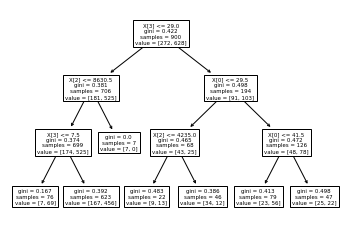

In [563]:
tree.plot_tree(model)

In [564]:
X_train_.columns

Index(['age', 'job', 'creditAmount', 'duration'], dtype='object')

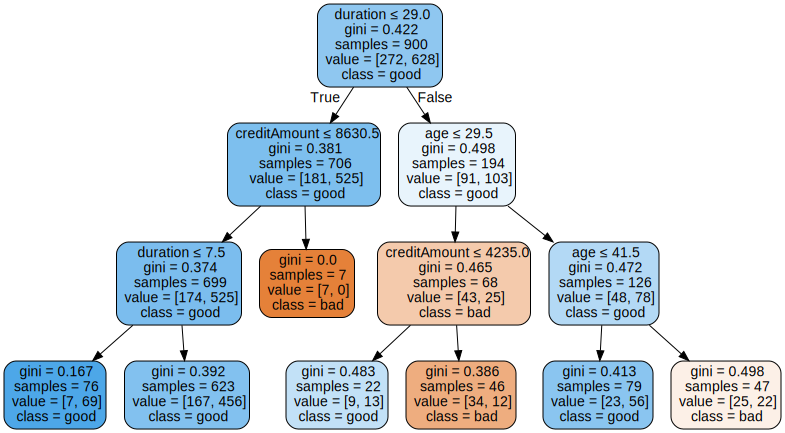

In [565]:
import graphviz
g = tree.export_graphviz(model, out_file=None, 
                      feature_names=X_train_.columns,  
                      class_names=['bad','good'],   
                      filled=True, rounded=True,  
                      special_characters=True)

graph = graphviz.Source(g) 
graph

In [566]:
from sklearn import tree
for i in [1,2,3,4,5,6,7,8,9,10,None]:
    model = tree.DecisionTreeClassifier(max_depth=i)
    model = model.fit(X_train_, y_train)
    s = make_scorer(f1_score, pos_label='bad')
    scores = cross_val_score(model, X_train_, y_train, cv=5, scoring=s)
    print("Max depth = "+ str(i)+ " f1-score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

Max depth = 1 f1-score: 0.03 (+/- 0.07)
Max depth = 2 f1-score: 0.17 (+/- 0.05)
Max depth = 3 f1-score: 0.21 (+/- 0.10)
Max depth = 4 f1-score: 0.22 (+/- 0.05)
Max depth = 5 f1-score: 0.26 (+/- 0.04)
Max depth = 6 f1-score: 0.32 (+/- 0.05)
Max depth = 7 f1-score: 0.29 (+/- 0.06)
Max depth = 8 f1-score: 0.33 (+/- 0.04)
Max depth = 9 f1-score: 0.32 (+/- 0.04)
Max depth = 10 f1-score: 0.35 (+/- 0.05)
Max depth = None f1-score: 0.37 (+/- 0.04)


In [567]:
from sklearn import tree
from sklearn.model_selection import cross_val_score
model = tree.DecisionTreeClassifier()
model = model.fit(X_train_, y_train)
y_pred = cross_val_predict(model, X_train_, y_train, cv=5)
print("f1-score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

f1-score: 0.37 (+/- 0.04)


In [568]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_train, y_pred))
from sklearn.metrics import classification_report, plot_confusion_matrix
print(classification_report(y_train, y_pred))

[[ 99 173]
 [162 466]]
              precision    recall  f1-score   support

         bad       0.38      0.36      0.37       272
        good       0.73      0.74      0.74       628

    accuracy                           0.63       900
   macro avg       0.55      0.55      0.55       900
weighted avg       0.62      0.63      0.63       900



In [569]:
#
# Roubo! Validando modelo no conjunto de treinamento
# Objetivo: mostrar o quanto que uma árvore de decisão sem poda faz overfitting.
#
from sklearn.metrics import f1_score
predicted = model.predict(X_train_)
f1_score(predicted, y_train, pos_label='bad')

1.0

# Modelando com Knn (Aprendizado baseado em instâncias)

O algoritmo Knn só consegue manipular atributos independentes numéricos. E os mesmos precisam estar normalizados. Por isso, teremos que normalizar (https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc). 

In [570]:
X_train_.head()

,age,job,creditAmount,duration
239,39,2,2522,30
304,44,2,10127,48
964,22,1,454,6
102,24,2,932,6
867,42,2,3331,12


In [571]:
from sklearn import preprocessing
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

X_train_scaled = pd.DataFrame(min_max_scaler.fit_transform(X_train_), 
                              index=X_train_.index, 
                              columns=X_train_.columns
                             )

In [572]:
X_train_scaled.head()

,age,job,creditAmount,duration
239,0.357143,0.666667,0.125014,0.382353
304,0.446429,0.666667,0.543469,0.647059
964,0.053571,0.333333,0.011225,0.029412
102,0.089286,0.666667,0.037526,0.029412
867,0.410714,0.666667,0.169528,0.117647


In [573]:
# melhor k
k = X_train_scaled.shape[0]**(1/2)
k

30.0

In [577]:
from sklearn.neighbors import KNeighborsClassifier
result = []
for i in range(1,60):
    modelK = KNeighborsClassifier(n_neighbors=i)
    modelK.fit(X_train_scaled, y_train)
    s = make_scorer(f1_score, pos_label='bad')
    scores = cross_val_score(modelK, X_train_scaled, y_train, cv=5, scoring=s)
    f1 = scores.mean()
    result.append((i, f1))

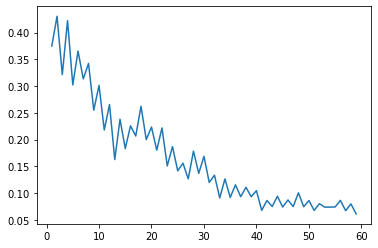

In [578]:
plt.plot(*zip(*result))

In [579]:
result[0:5]

[(1, 0.37485766187601055),
 (2, 0.43050287301790213),
 (3, 0.3213385735786737),
 (4, 0.4223096297402641),
 (5, 0.3021711312281643)]

In [580]:
modelK = KNeighborsClassifier(n_neighbors=2)
modelK.fit(X_train_scaled, y_train)
s = make_scorer(f1_score, pos_label='bad')
scores = cross_val_score(modelK, X_train_scaled, y_train, cv=5, scoring=s)
y_pred = cross_val_predict(modelK, X_train_scaled, y_train, cv=5)
print("f1-score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

f1-score: 0.43 (+/- 0.03)


In [581]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_train, y_pred))
from sklearn.metrics import classification_report, plot_confusion_matrix
print(classification_report(y_train, y_pred))

[[157 115]
 [300 328]]
              precision    recall  f1-score   support

         bad       0.34      0.58      0.43       272
        good       0.74      0.52      0.61       628

    accuracy                           0.54       900
   macro avg       0.54      0.55      0.52       900
weighted avg       0.62      0.54      0.56       900



# Modelando com Knn + one hot para todos os atributos categóricos

Por enquanto, vamos desconsiderar os atributos savingAccount e checkingAccount - atributos que possuem valores faltantes.

In [582]:
X_train.head()

,age,sex,job,housing,savingAccount,checkingAccount,creditAmount,duration,purpose
239,39,male,2,own,1.0,1.0,2522,30,radio/TV
304,44,male,2,free,3.0,NaN,10127,48,car
964,22,male,1,own,1.0,2.0,454,6,repairs
102,24,female,2,own,1.0,NaN,932,6,radio/TV
867,42,male,2,own,1.0,NaN,3331,12,furniture/equipment


In [583]:
d_attr = pd.get_dummies(X_train[['sex','housing','purpose']], prefix=['sex','housing','purpose'])

In [584]:
print(d_attr.shape)
print(X_train_scaled.shape)

(900, 13)
(900, 4)


In [585]:
X_train_knn = pd.concat([X_train_scaled, d_attr], axis=1)

In [586]:
X_train_knn.head()

,age,job,creditAmount,duration,sex_female,sex_male,housing_free,housing_own,housing_rent,purpose_business,purpose_car,purpose_domestic appliances,purpose_education,purpose_furniture/equipment,purpose_radio/TV,purpose_repairs,purpose_vacation/others
239,0.357143,0.666667,0.125014,0.382353,0,1,0,1,0,0,0,0,0,0,1,0,0
304,0.446429,0.666667,0.543469,0.647059,0,1,1,0,0,0,1,0,0,0,0,0,0
964,0.053571,0.333333,0.011225,0.029412,0,1,0,1,0,0,0,0,0,0,0,1,0
102,0.089286,0.666667,0.037526,0.029412,1,0,0,1,0,0,0,0,0,0,1,0,0
867,0.410714,0.666667,0.169528,0.117647,0,1,0,1,0,0,0,0,0,1,0,0,0


In [587]:
X_train_knn.shape

(900, 17)

In [588]:
from sklearn.neighbors import KNeighborsClassifier
result = []
for i in range(1,60):
    modelK = KNeighborsClassifier(n_neighbors=i)
    modelK.fit(X_train_knn, y_train)
    s = make_scorer(f1_score, pos_label='bad')
    scores = cross_val_score(modelK, X_train_knn, y_train, cv=5, scoring=s)
    f1 = scores.mean()
    result.append((i, f1))

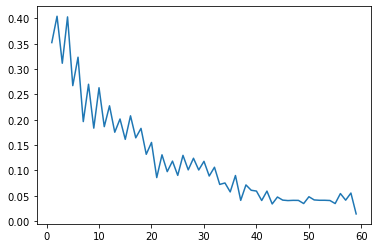

In [589]:
plt.plot(*zip(*result))

In [590]:
result[0:5]

[(1, 0.35211849062853584),
 (2, 0.40408348457350274),
 (3, 0.31137848037816707),
 (4, 0.4028038635549481),
 (5, 0.2672498662884309)]

In [591]:
modelK = KNeighborsClassifier(n_neighbors=4)
modelK.fit(X_train_knn, y_train)
s = make_scorer(f1_score, pos_label='bad')
scores = cross_val_score(modelK, X_train_knn, y_train, cv=5, scoring=s)
y_pred = cross_val_predict(modelK, X_train_knn, y_train, cv=5)
print("f1_score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

f1_score: 0.40 (+/- 0.07)


In [592]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_train, y_pred))
from sklearn.metrics import classification_report, plot_confusion_matrix
print(classification_report(y_train, y_pred))

[[119 153]
 [197 431]]
              precision    recall  f1-score   support

         bad       0.38      0.44      0.40       272
        good       0.74      0.69      0.71       628

    accuracy                           0.61       900
   macro avg       0.56      0.56      0.56       900
weighted avg       0.63      0.61      0.62       900



# Usando ensemble models (RandomForest)

Vamos usar o mesmo pré-processamento utilizado para o algoritmo Knn

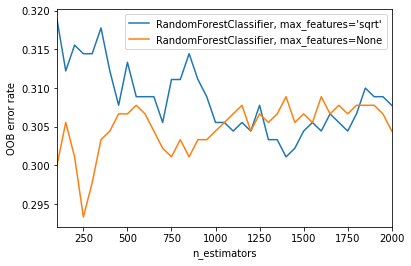

In [595]:
%matplotlib inline
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 123

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 100
max_estimators = 2000
step = 50

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators+step, step):
        clf.set_params(n_estimators=i)
        clf.fit(X_train_knn, y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [597]:
clf.n_outputs_

1

In [436]:
clf = RandomForestClassifier(n_estimators=250,
                             warm_start=True, max_features=None,
                             oob_score=True,
                             random_state=RANDOM_STATE)
clf.fit(X_train_knn, y_train)

RandomForestClassifier(max_features=None, n_estimators=250, oob_score=True,
                       random_state=123, warm_start=True)

In [437]:
clf.oob_score_

0.7066666666666667